In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
location = 'nw2'
turbine = 'c02'
mode = 'SS2'

In [4]:
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
selected_data_little = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_little.csv'))
selected_data_large = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))

In [5]:
from src.data.utils import get_input_data
from src.data.harmonics import *

data = get_input_data(data_folder, location, turbine)
harmonics_data = harmonics(data['turbine_data'].filter(regex='rpm'), [1,3,6, 9])

In [6]:
selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature']

In [7]:
#smart tracking
def smart_tracking(calculated_mode, predictions, uncertainties:pd.Series, uncerainty_threshold, distance_threshold):
    tracked_modes = pd.DataFrame(calculated_mode.values, index=calculated_mode.index, columns=['frequency'])
    tracked_modes = tracked_modes.loc[uncertainties[uncertainties < uncerainty_threshold].index]
    tracked_modes['distance_to_prediction'] = np.abs(tracked_modes['frequency'] - predictions.loc[tracked_modes.index])
    smart_tracked_modes = tracked_modes[tracked_modes['distance_to_prediction'] < distance_threshold]
    return smart_tracked_modes

dropped mvbc columns:  {'mvbc_WandelaarBuoy_Sea_water_temperature', 'mvbc_WandelaarMeasuringpile_Relative_humidity'}


C:\Users\Max\AppData\Local\Temp\ipykernel_24452\2735685574.py:74: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_24452\2735685574.py:101: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


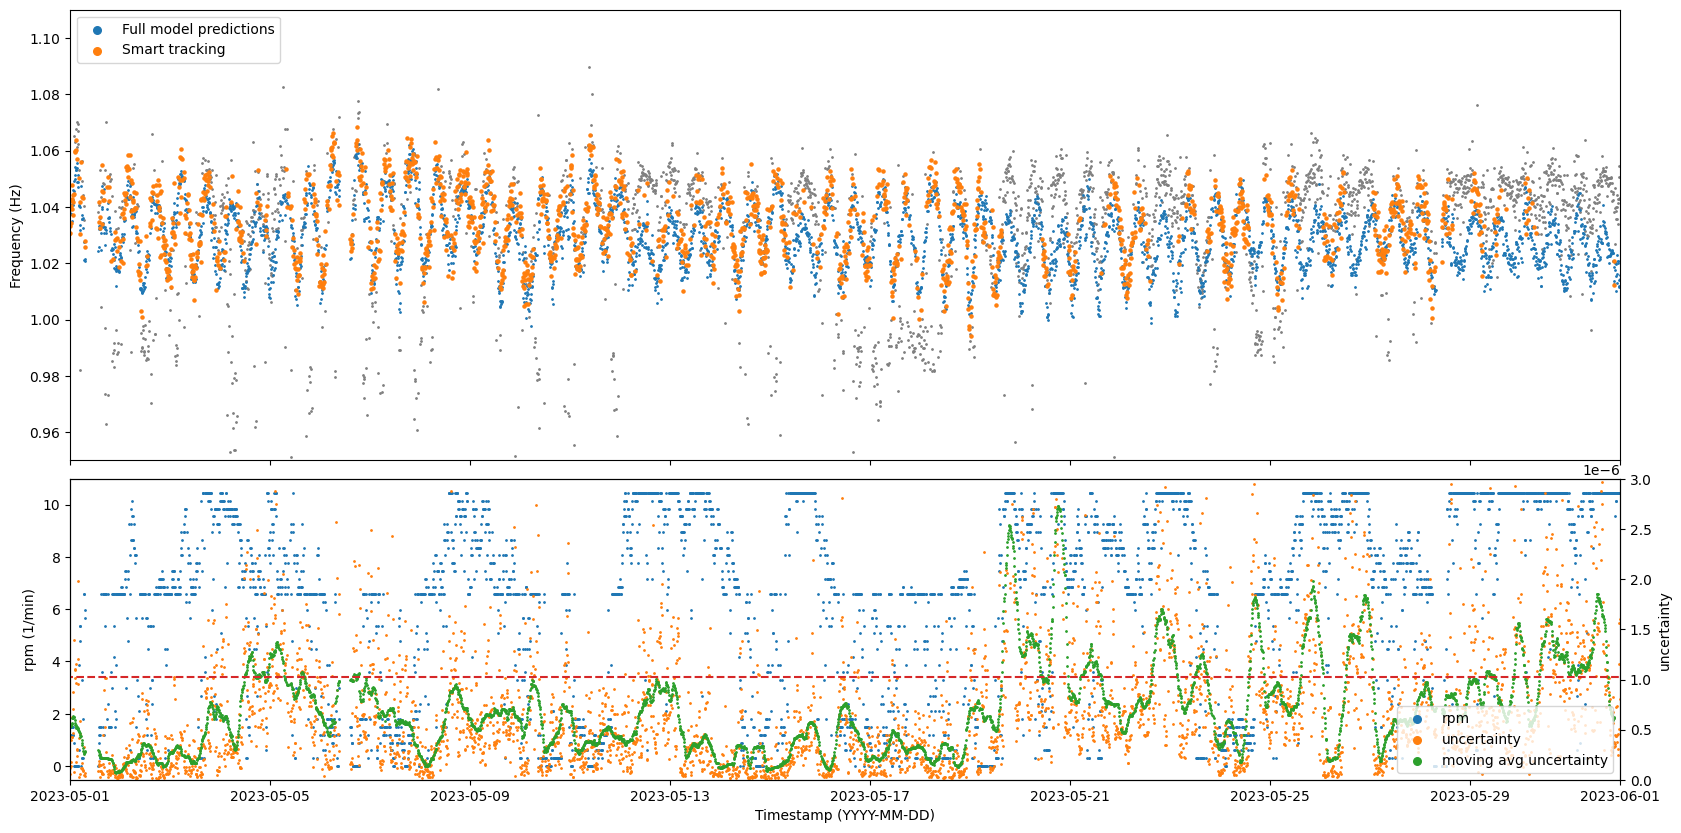

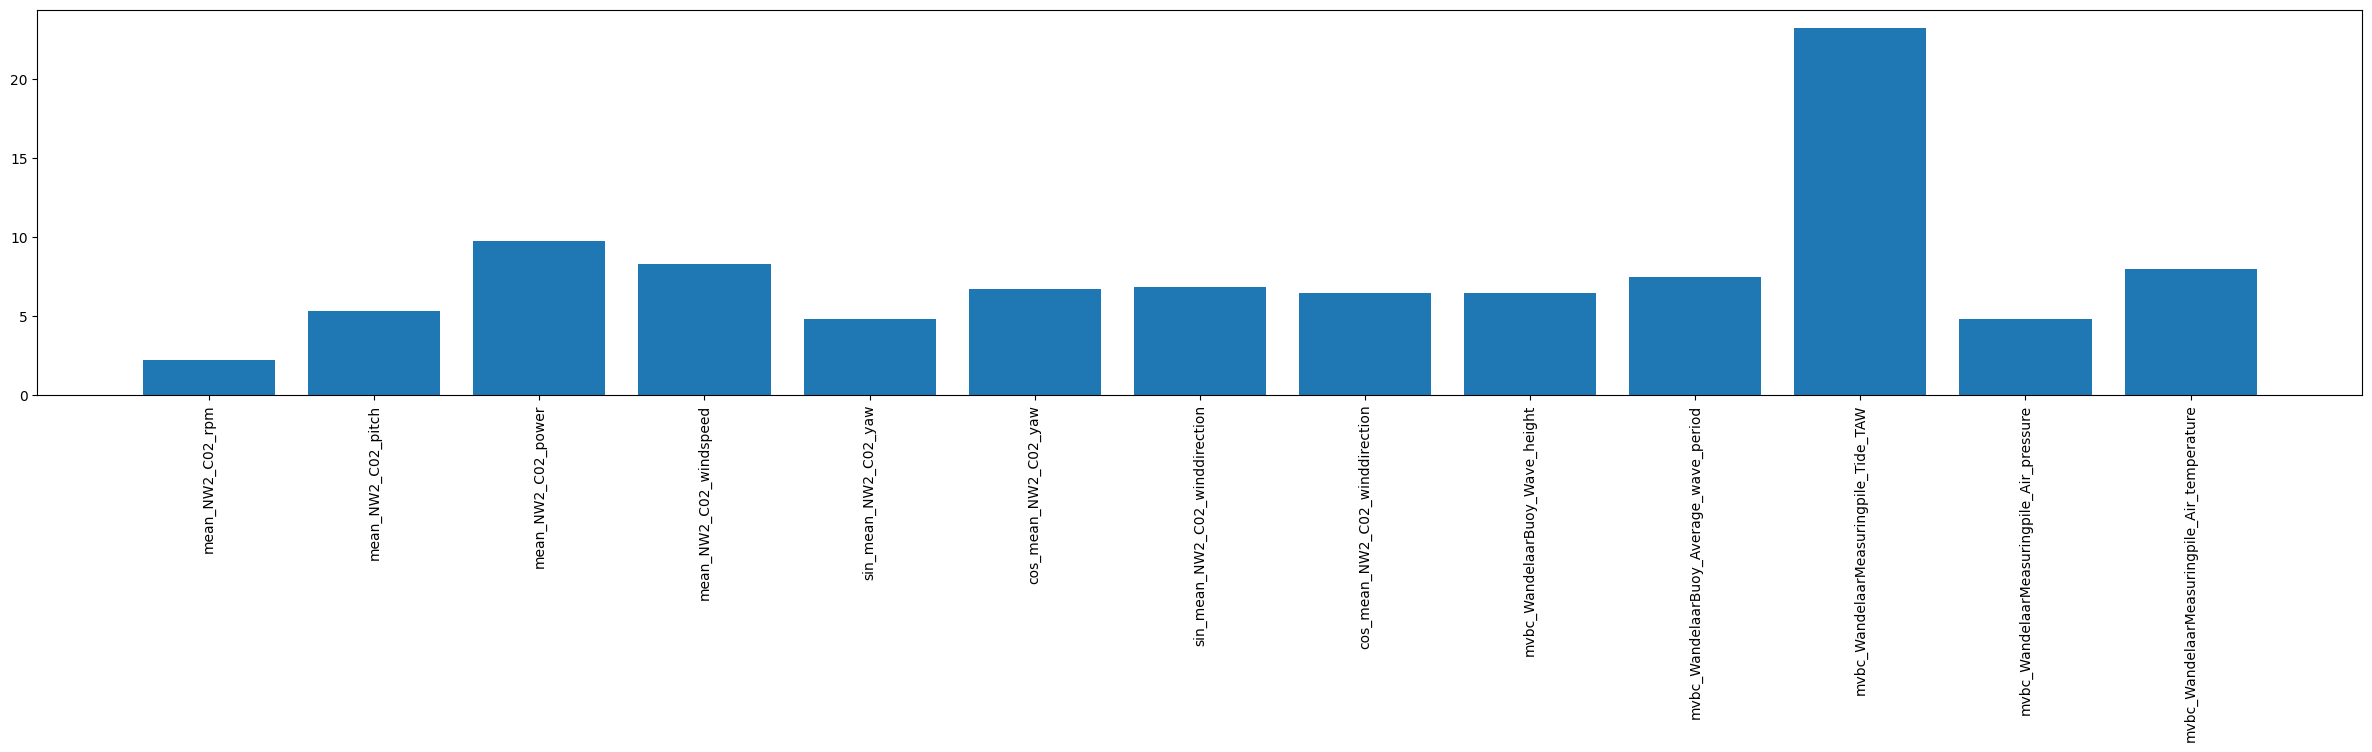

In [8]:
from src.data.make_dataset import create_input_target_dataset
X, y = create_input_target_dataset(data_folder, location, turbine, mode)

# Remove the selected data with duplicated timestamps and keep the one with the biggest size
selected_data_sorted = selected_data_little.sort_values(by='size', ascending=False)
selected_data_unique = selected_data_sorted.drop_duplicates(subset='timestamp', keep='first')
selected_data_unique = selected_data_unique.sort_values(by='timestamp')

y_train = selected_data_unique[['mean_frequency']].set_index(selected_data_unique['timestamp'])
y_train.index = pd.to_datetime(y_train.index)
y_train = y_train.loc[y_train.index.intersection(X.index)]
X_train = X.loc[y_train.index]
X_train = X_train[selected_columns]

from catboost import CatBoostRegressor
regr_model = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.5, random_seed=13,posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

import pickle
models_folder = os.path.join(package_folder, 'models', location)
model_path = os.path.join(models_folder, '_'.join([location, turbine, mode, 'catboost_model_small.pkl']))
with open(model_path, 'wb') as file:
    pickle.dump(regr_model, file)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty

import matplotlib.pyplot as plt
import datetime

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_moving_avg.loc[X_train.index].quantile(0.99)
prediction_lim = (y - predictions_df['prediction']).loc[X_train.index].quantile(0.99)

smart_tracked_modes = smart_tracking(y, predictions_df['prediction'], uncertainty_moving_avg, uncertainty_lim, prediction_lim)
smart_tracked_modes.to_csv(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_smart_tracked_modes_small_training.csv'))
smart_tracked_modes.to_parquet(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_smart_tracked_modes_small_training.parquet'))

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y - predictions_df['prediction']

#predictions_df.to_csv(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_mode_prediction_small_training.csv'))
predictions_df.to_parquet(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_mode_prediction_small_training.parquet'))

y_low_uncertainty = y.loc[uncertainty_moving_avg < uncertainty_lim]
# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=1, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=5, color='tab:orange', label='Smart tracking')
ax1.set_ylim(0.95, 1.11)
legend1 = ax1.legend(loc='upper left')

for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')

# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.xlim(datetime.datetime(2023, 5, 1), datetime.datetime(2023, 6, 1))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed

plt.show()
plt.close()

plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()
plt.close()


In [9]:
print('uncertainty 90% quantile', uncertainty_.quantile(0.9))
print('uncertainty 95% quantile', uncertainty_.quantile(0.95))
print('uncertainty 99% quantile', uncertainty_.quantile(0.99))
print('uncertainty std', uncertainty_.std())
print('uncertainty 3 sigma', uncertainty_.std()*3)

print('uncertainty moving avg 90% quantile', uncertainty_moving_avg.quantile(0.90))
print('uncertainty moving avg 95% quantile', uncertainty_moving_avg.quantile(0.95))
print('uncertainty moving avg 99% quantile', uncertainty_moving_avg.quantile(0.99))
print('uncertainty moving avg std', uncertainty_moving_avg.std())
print('uncertainty moving avg 3 sigma', uncertainty_moving_avg.std()*3)

uncertainty 90% quantile 1.467068514614061e-06
uncertainty 95% quantile 2.0688376516827546e-06
uncertainty 99% quantile 3.665755774038351e-06
uncertainty std 7.528188747966661e-07
uncertainty 3 sigma 2.2584566243899984e-06
uncertainty moving avg 90% quantile 1.2992696968759193e-06
uncertainty moving avg 95% quantile 1.6982104464767e-06
uncertainty moving avg 99% quantile 2.47083821481364e-06
uncertainty moving avg std 5.338879924738729e-07
uncertainty moving avg 3 sigma 1.6016639774216188e-06


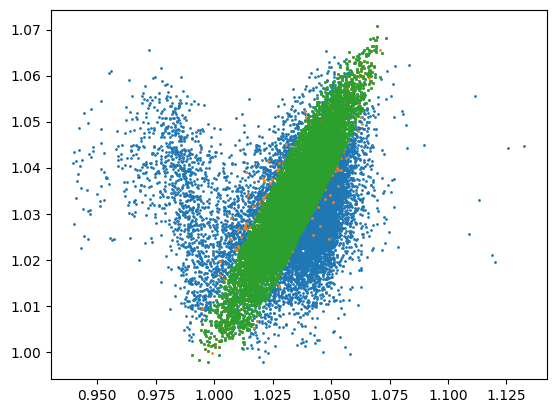

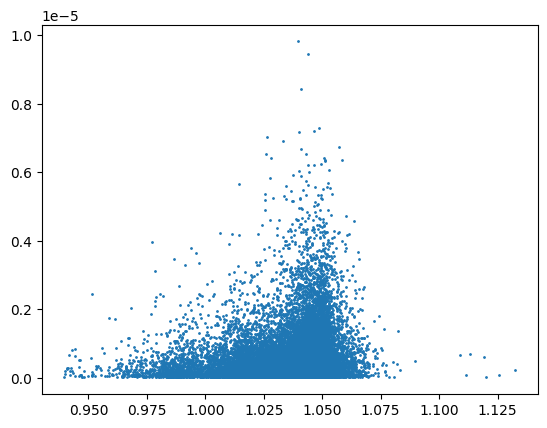

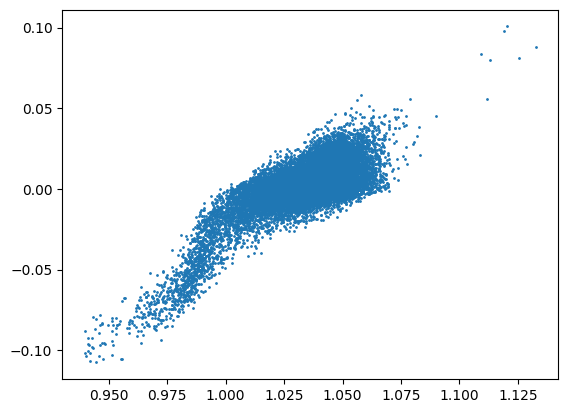

In [10]:
plt.scatter(y, predicted_value, s=1)
plt.scatter(y_train, pd.Series(predicted_value,index=y.index).loc[y_train.index], s=1)
plt.scatter(y.loc[smart_tracked_modes.index], pd.Series(predicted_value,index=y.index).loc[smart_tracked_modes.index], s=1)

#plt.plot(np.arange(0.95,1.125,0.01), np.arange(0.95,1.125,0.01), color='k')
plt.show()
plt.close()
plt.scatter(y, uncertainty_, s=1)
plt.show()
plt.close()
plt.scatter(y, y-predicted_value, s=1)

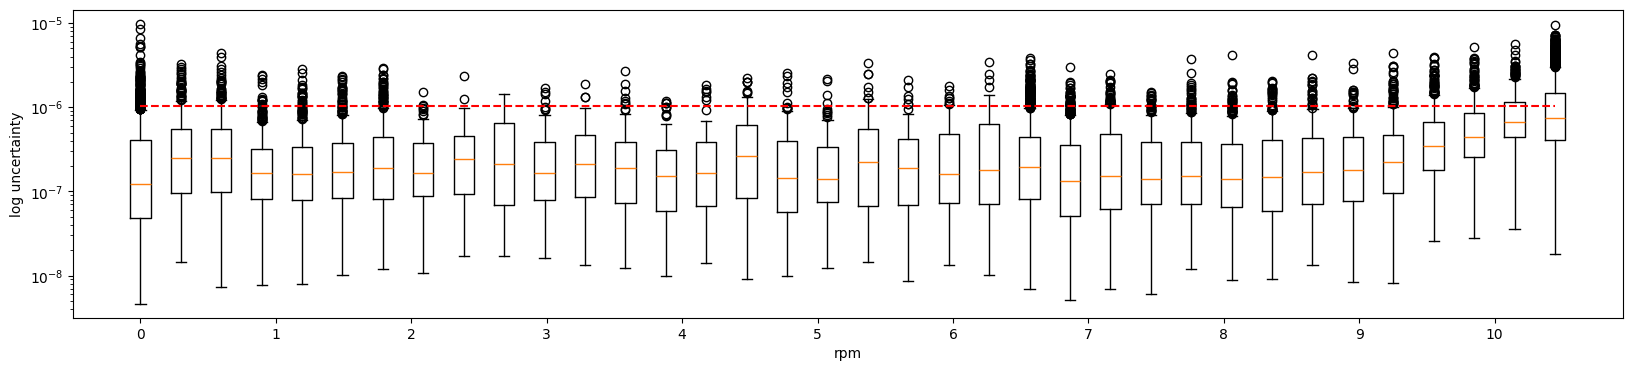

In [11]:
boxplot_data = pd.DataFrame({'uncertainty':uncertainty_.values, 'rpm':X.filter(regex='rpm').values[:,0]})
rpms = np.unique(boxplot_data['rpm'])
plt.figure(figsize=(20,4))
for rpm in rpms:
    # Make a boxplot at the x value of the rpm
    plt.boxplot(boxplot_data[boxplot_data['rpm']==rpm]['uncertainty'], positions=[rpm])
plt.yscale('log')  
plt.ylabel('log uncertainty')
plt.xlabel('rpm')
plt.hlines(uncertainty_lim, 0, X.filter(regex='rpm').max(), color='red', linestyle='--')
# Only show one x tick every 5 ticks
plt.xticks(np.arange(11), np.arange(11))
plt.show()
plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_24452\836857019.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_24452\836857019.py:54: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


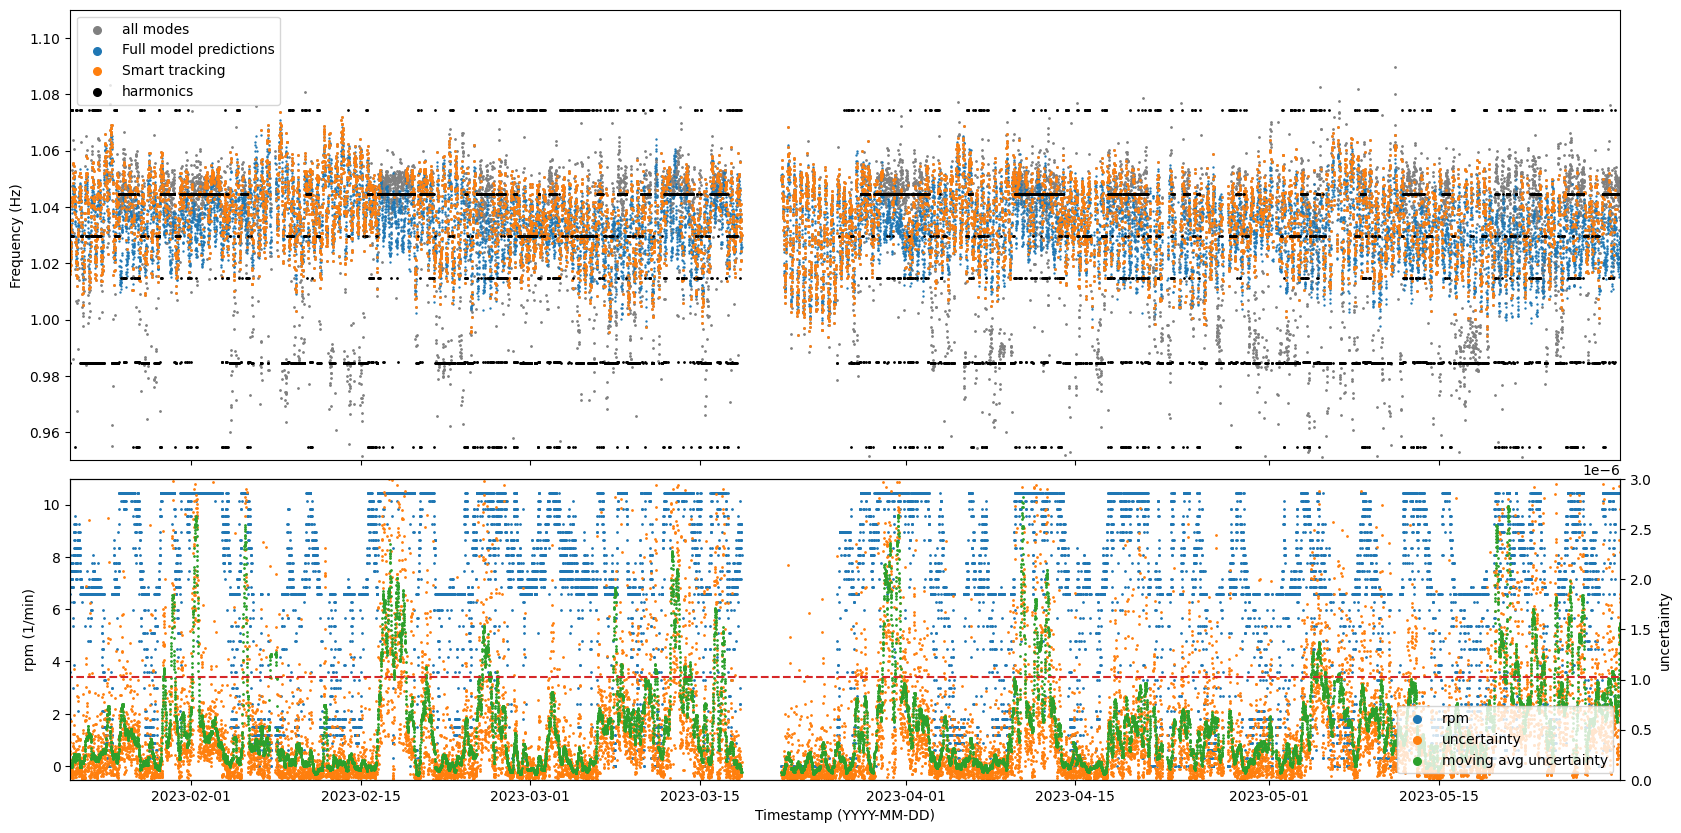

In [12]:
import matplotlib.pyplot as plt
import datetime

# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=0.5, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:orange', label='Smart tracking')
for harmonic in harmonics_data.columns:
    ax1.scatter(harmonics_data.index, harmonics_data[harmonic], color='k', s=1)

#ax1.plot(harmonics_data, color='k', linestyle='--', linewidth=0.5, label='harmonics')
#ax1.scatter(y_train.index, y_train, s=3, color='tab:blue', label='training data')
#ax1.scatter(y.index, predicted_value, s=2, color='tab:orange', label='Full model predictions')


#ax1.scatter(y.index, virtual_ensemble_preds_mean, s=2, color='tab:green', label='Virtual ensemble mean predictions')

ax1.set_ylim(0.95, 1.11)
legend1 = ax1.legend(loc='upper left', labels = ['all modes', 'Full model predictions', 'Smart tracking', 'harmonics'])
for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')


# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')
#ax2.scatter(X.index, data_uncertainty, label='data uncertainty', s=1, color='tab:blue')
#ax2.set_ylim(0, 1e-5)

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.xlim(datetime.datetime(2023, 1, 22), datetime.datetime(2023, 5, 30))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed


plt.show()
plt.close()

# Add the data from 05/05 to 09/05 to training data

dropped mvbc columns:  {'mvbc_WandelaarBuoy_Sea_water_temperature', 'mvbc_WandelaarMeasuringpile_Relative_humidity'}


C:\Users\Max\AppData\Local\Temp\ipykernel_24452\1562811376.py:73: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_24452\1562811376.py:100: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


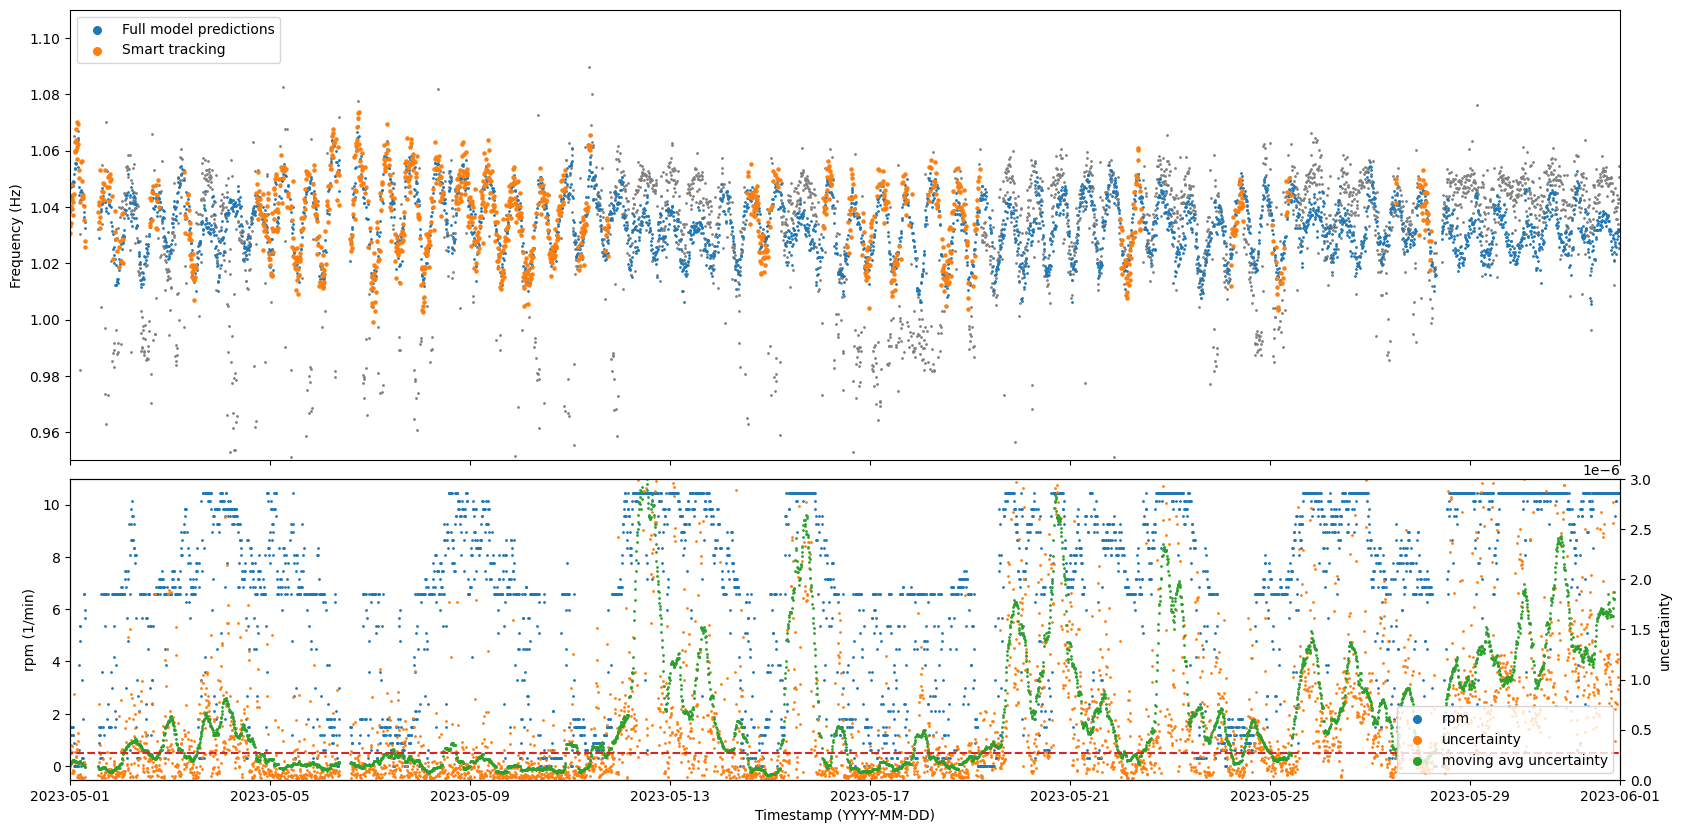

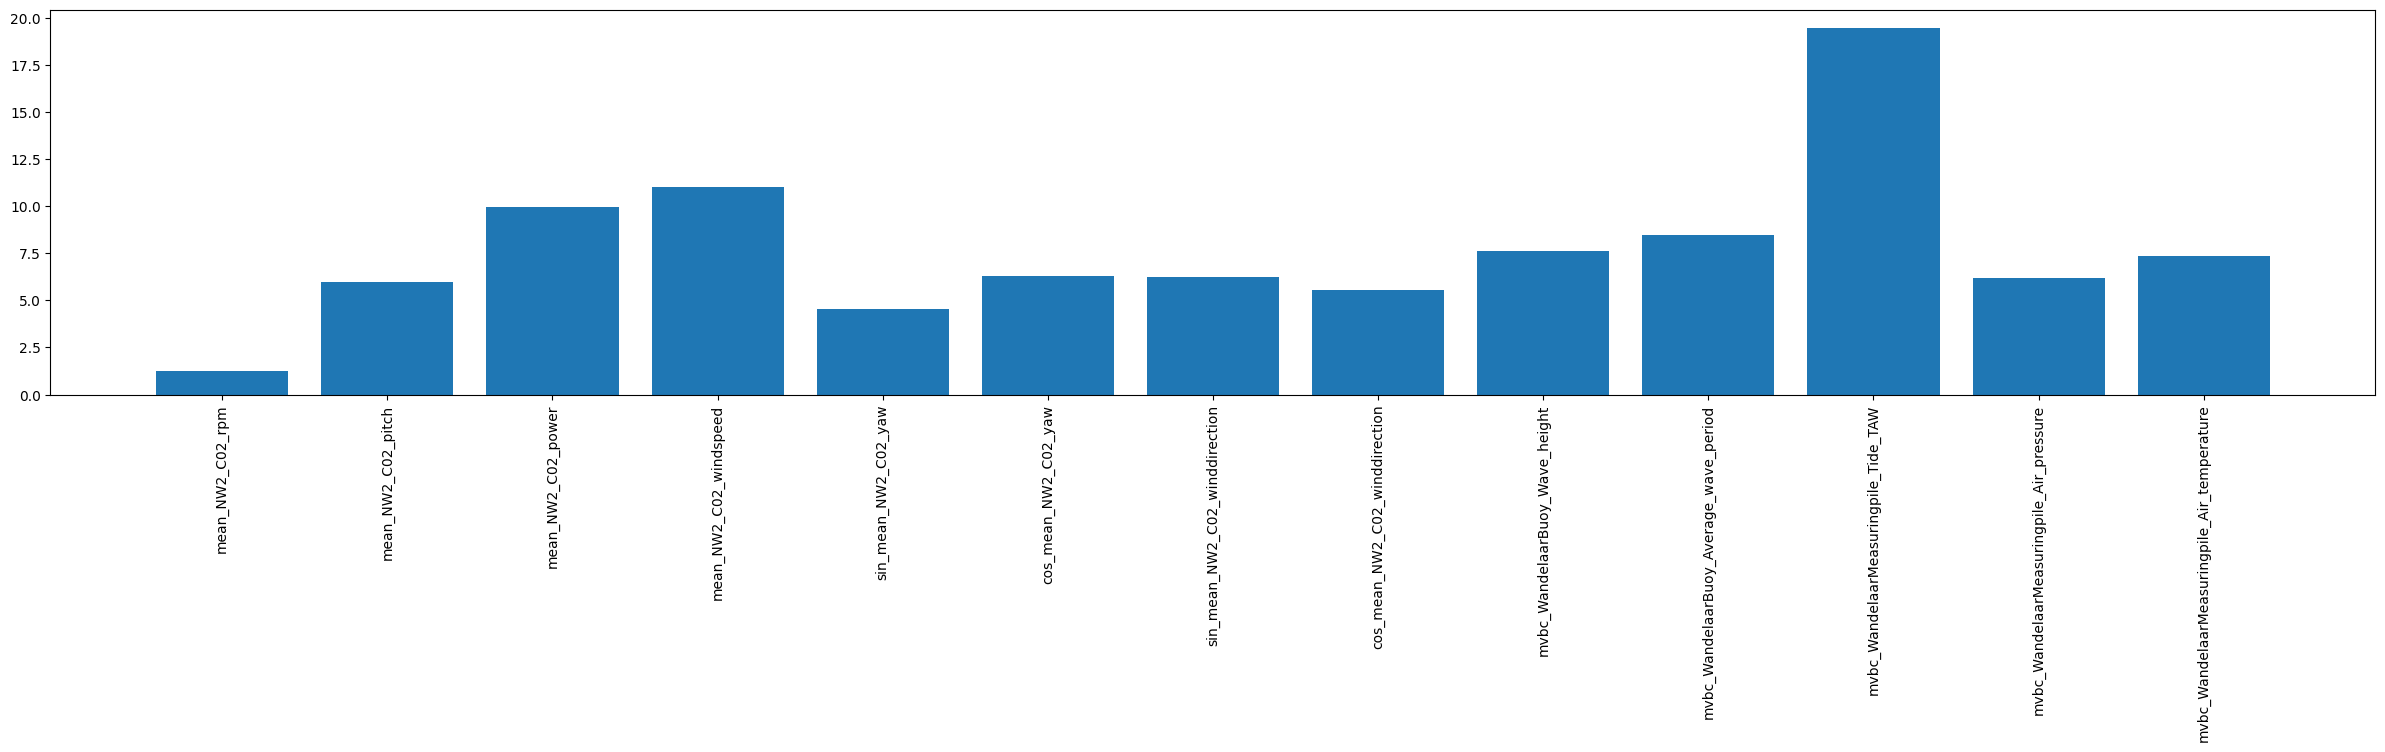

In [13]:
from src.data.make_dataset import create_input_target_dataset
X, y = create_input_target_dataset(data_folder, location, turbine, mode)

# Remove the selecyted data with duplicated timestamps and keep the one with the biggest size
selected_data_sorted = selected_data_large.sort_values(by='size', ascending=False)
selected_data_unique = selected_data_sorted.drop_duplicates(subset='timestamp', keep='first')
selected_data_unique = selected_data_unique.sort_values(by='timestamp')

y_train = selected_data_unique[['mean_frequency']].set_index(selected_data_unique['timestamp'])
y_train.index = pd.to_datetime(y_train.index)
y_train = y_train.loc[y_train.index.intersection(X.index)]
X_train = X.loc[y_train.index]
X_train = X_train[selected_columns]

from catboost import CatBoostRegressor
regr_model = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.5, random_seed=13,posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

import pickle
models_folder = os.path.join(package_folder, 'models', location)
model_path = os.path.join(models_folder, turbine, mode, 'catboost_model_large.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(regr_model, file)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

import matplotlib.pyplot as plt
import datetime

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_moving_avg.loc[X_train.index].quantile(0.9)

prediction_lim = (y - predictions_df['prediction']).loc[X_train.index].quantile(0.99)

smart_tracked_modes = smart_tracking(y, predictions_df['prediction'], uncertainty_moving_avg, uncertainty_lim, prediction_lim)
#smart_tracked_modes.to_csv(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_smart_tracked_modes_large_training.csv'))
smart_tracked_modes.to_parquet(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_smart_tracked_modes_large_training.parquet'))

model_path = os.path.join(models_folder, '_'.join([location, turbine, mode, 'catboost_model_large.pkl']))

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y - predictions_df['prediction']

#predictions_df.to_csv(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_mode_prediction_large_training.csv'))
predictions_df.to_parquet(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_mode_prediction_large_training.parquet'))

y_low_uncertainty = y.loc[uncertainty_moving_avg < uncertainty_lim]
# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=1, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=5, color='tab:orange', label='Smart tracking')
ax1.set_ylim(0.95, 1.11)
legend1 = ax1.legend(loc='upper left')

for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')

# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.xlim(datetime.datetime(2023, 5, 1), datetime.datetime(2023, 6, 1))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed

plt.show()
plt.close()

plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()
plt.close()


In [14]:
pd.Series(y_train.values[:,0]  - predictions_df['prediction'].loc[y_train.index].values, index=y_train.index).quantile(0.99)

0.012008446710049168

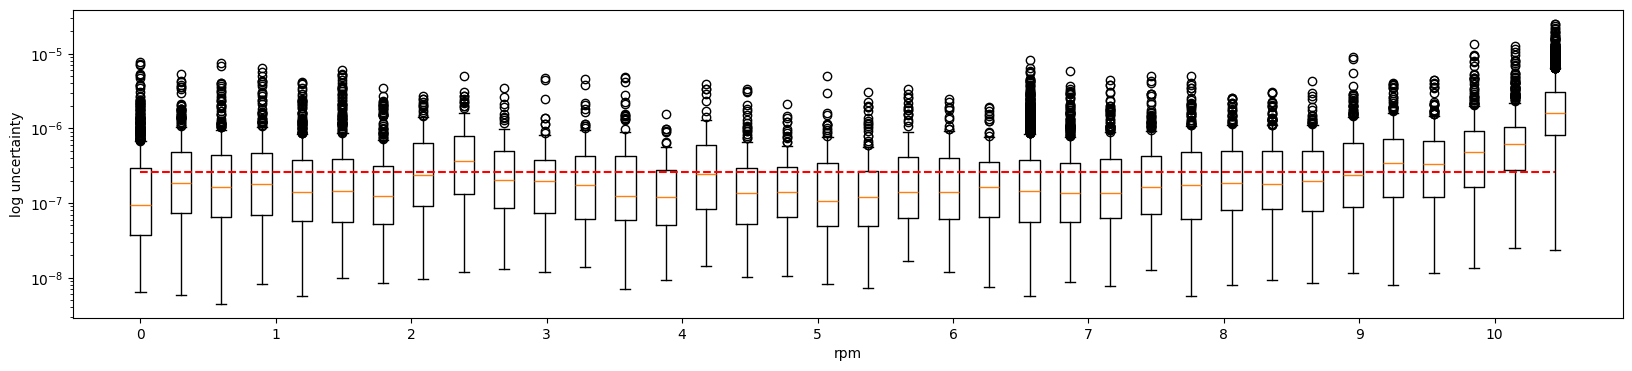

In [15]:
boxplot_data = pd.DataFrame({'uncertainty':uncertainty_.values, 'rpm':X.filter(regex='rpm').values[:,0]})
rpms = np.unique(boxplot_data['rpm'])
plt.figure(figsize=(20,4))
for rpm in rpms:
    # Make a boxplot at the x value of the rpm
    plt.boxplot(boxplot_data[boxplot_data['rpm']==rpm]['uncertainty'], positions=[rpm])
plt.yscale('log')  
plt.ylabel('log uncertainty')
plt.xlabel('rpm')
plt.hlines(uncertainty_lim, 0, X.filter(regex='rpm').max(), color='red', linestyle='--')
# Only show one x tick every 5 ticks
plt.xticks(np.arange(11), np.arange(11))
plt.show()
plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_24452\4036762179.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_24452\4036762179.py:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


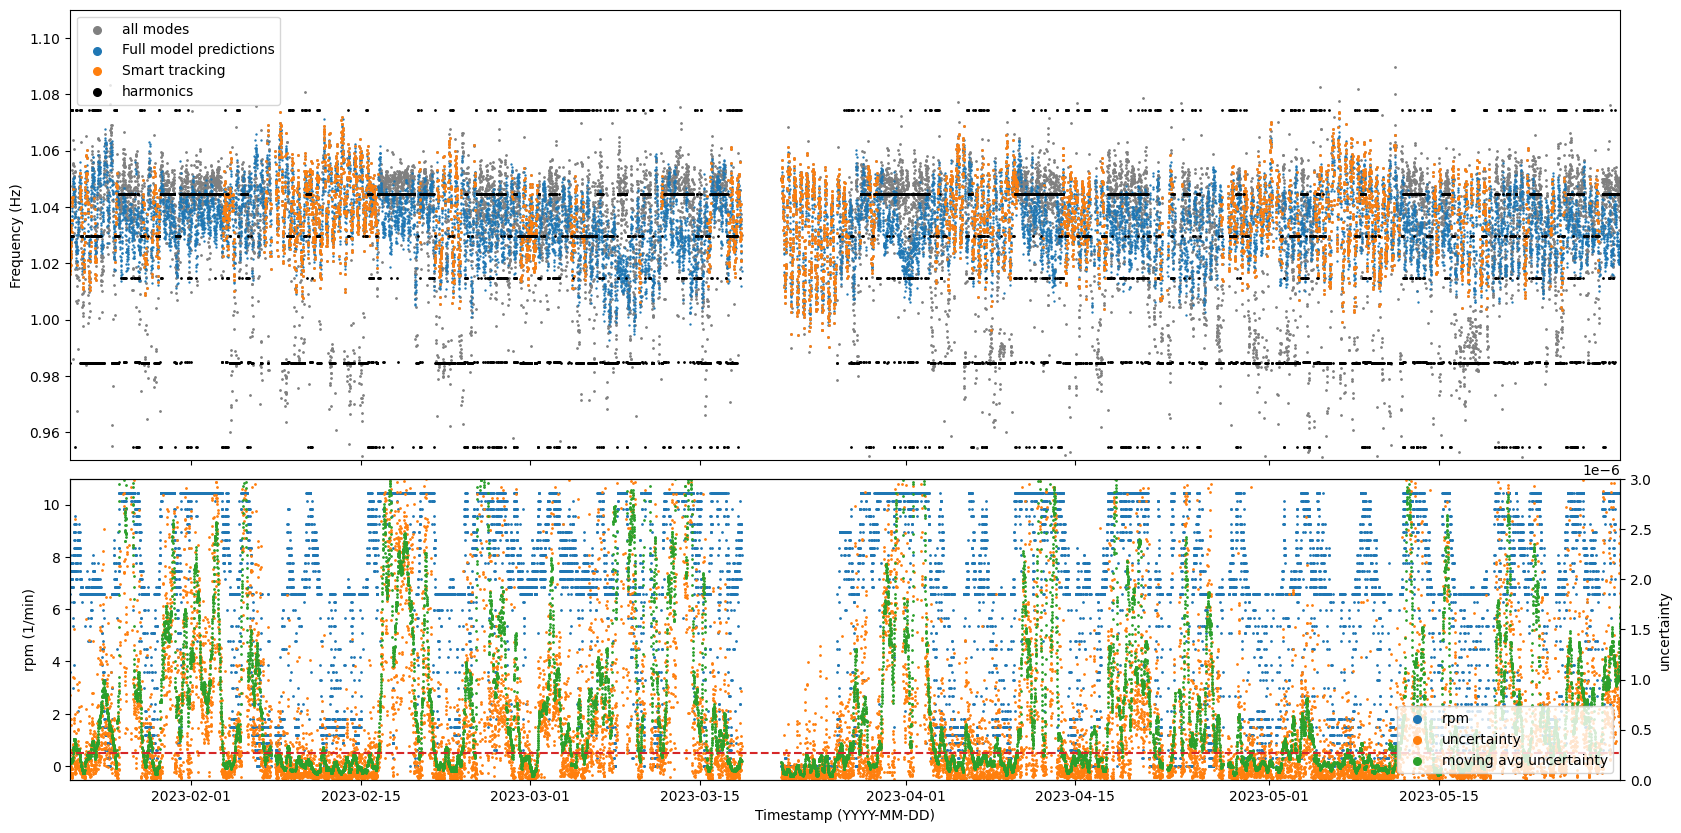

In [16]:
import matplotlib.pyplot as plt
import datetime

# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=0.5, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:orange', label='Smart tracking')
for harmonic in harmonics_data.columns:
    ax1.scatter(harmonics_data.index, harmonics_data[harmonic], color='k', s=1)

#ax1.plot(harmonics_data, color='k', linestyle='--', linewidth=0.5, label='harmonics')
#ax1.scatter(y_train.index, y_train, s=3, color='tab:blue', label='training data')
#ax1.scatter(y.index, predicted_value, s=2, color='tab:orange', label='Full model predictions')


#ax1.scatter(y.index, virtual_ensemble_preds_mean, s=2, color='tab:green', label='Virtual ensemble mean predictions')

ax1.set_ylim(0.95, 1.11)
legend1 = ax1.legend(loc='upper left', labels = ['all modes', 'Full model predictions', 'Smart tracking', 'harmonics'])
for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')


# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')
#ax2.scatter(X.index, data_uncertainty, label='data uncertainty', s=1, color='tab:blue')
#ax2.set_ylim(0, 1e-5)

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.xlim(datetime.datetime(2023, 1, 22), datetime.datetime(2023, 5, 30))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed


plt.show()
plt.close()

In [17]:
uncerinty_limits = pd.DataFrame(
    {
        'uncertainty': [
            uncertainty_.loc[X_train.index].quantile(0.9), 
            uncertainty_.loc[X_train.index].quantile(0.95), 
            uncertainty_.loc[X_train.index].quantile(0.99), 
            uncertainty_.loc[X_train.index].std(), 
            uncertainty_.loc[X_train.index].std()*3
            ],
        'uncertainty_moving_avg': [
            uncertainty_moving_avg.loc[X_train.index].quantile(0.90), 
            uncertainty_moving_avg.loc[X_train.index].quantile(0.95), 
            uncertainty_moving_avg.loc[X_train.index].quantile(0.99), 
            uncertainty_moving_avg.loc[X_train.index].std(), 
            uncertainty_moving_avg.loc[X_train.index].std()*3
            ],
        'residual': [
            (y - predictions_df['prediction']).loc[X_train.index].quantile(0.9), 
            (y - predictions_df['prediction']).loc[X_train.index].quantile(0.95), 
            (y - predictions_df['prediction']).loc[X_train.index].quantile(0.99), 
            (y - predictions_df['prediction']).loc[X_train.index].std(), 
            (y - predictions_df['prediction']).loc[X_train.index].std()*3
            ]

    },
    index = ['quantile 90%', 'quantile 95%', 'quantile 99%', 'std', '3 sigma'])

uncerinty_limits.to_parquet(os.path.join(data_folder, 'processed', location, turbine+'_'+mode+'_uncertainty_limits.parquet'))

In [23]:

print('uncertainty 80% quantile', uncertainty_.loc[X_train.index].quantile(0.8))

print('uncertainty 90% quantile', uncertainty_.loc[X_train.index].quantile(0.9))
print('uncertainty 95% quantile', uncertainty_.loc[X_train.index].quantile(0.95))
print('uncertainty 99% quantile', uncertainty_.loc[X_train.index].quantile(0.99))
print('uncertainty 99% quantile', uncertainty_.loc[X_train.index].quantile(0.996))

print('uncertainty std', uncertainty_.loc[X_train.index].std())
print('uncertainty 3 sigma', uncertainty_.loc[X_train.index].std()*3)

print('uncertainty moving avg 90% quantile', uncertainty_moving_avg.loc[X_train.index].quantile(0.90))
print('uncertainty moving avg 95% quantile', uncertainty_moving_avg.loc[X_train.index].quantile(0.95))
print('uncertainty moving avg 99% quantile', uncertainty_moving_avg.loc[X_train.index].quantile(0.99))
print('uncertainty moving avg std', uncertainty_moving_avg.loc[X_train.index].std())
print('uncertainty moving avg 3 sigma', uncertainty_moving_avg.loc[X_train.index].std()*3)

uncertainty 80% quantile 2.1331375333164705e-07
uncertainty 90% quantile 3.778378113097412e-07
uncertainty 95% quantile 5.902143777376365e-07
uncertainty 99% quantile 1.199509060664933e-06
uncertainty 99% quantile 1.5251241580238158e-06
uncertainty std 2.491114340379227e-07
uncertainty 3 sigma 7.473343021137681e-07
uncertainty moving avg 90% quantile 2.6368465309163476e-07
uncertainty moving avg 95% quantile 3.215489902573316e-07
uncertainty moving avg 99% quantile 4.5327128643510377e-07
uncertainty moving avg std 8.65027162807547e-08
uncertainty moving avg 3 sigma 2.595081488422641e-07


In [19]:
print('prediction_lim 99 quantile', (y - predictions_df['prediction']).loc[X_train.index].quantile(0.99))
print('prediction_lim 95 quantile', (y - predictions_df['prediction']).loc[X_train.index].quantile(0.95))
print('prediction_lim 90 quantile', (y - predictions_df['prediction']).loc[X_train.index].quantile(0.90))
print('prediction_lim std', (y - predictions_df['prediction']).loc[X_train.index].std())
print('prediction_lim 3 sigma', (y - predictions_df['prediction']).loc[X_train.index].std()*3)



prediction_lim 99 quantile 0.01234057134995788
prediction_lim 95 quantile 0.007743914933837235
prediction_lim 90 quantile 0.006053690035969961
prediction_lim std 0.013929963833652425
prediction_lim 3 sigma 0.04178989150095727


In [20]:
smart_tracked_modes

,frequency,distance_to_prediction
timestamp,,
2023-01-01 03:00:00+00:00,1.035454,0.000588
2023-01-01 03:10:00+00:00,1.030419,0.001538
2023-01-01 03:20:00+00:00,1.042198,0.008848
2023-01-01 03:30:00+00:00,1.019736,0.008695
2023-01-01 03:40:00+00:00,1.030911,0.000064
...,...,...
2023-05-28 04:20:00+00:00,1.027985,0.002404
2023-05-28 04:30:00+00:00,1.021256,0.004370
2023-05-28 04:40:00+00:00,1.017664,0.005806


In [21]:
uncertainty_lim

2.6368465309163476e-07

In [22]:
prediction_lim

0.01234057134995788